# Basic imports

In [31]:
%matplotlib inline

import gym
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import random
from IPython.display import HTML

import tqdm as tq

import torch
import torch.nn as nn
import torch.optim as optim

# Defining envirovment

## Creating Cart Pole env

In [2]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

In [3]:
env.action_space

Discrete(2)

## Testing Cart Pole env

In [4]:
env.reset()

(array([ 0.00307944,  0.04195269,  0.02535609, -0.01909792], dtype=float32),
 {})

**Interpretation of single action**
- first element represents state variables (cart position, cart velocity, pole angle, pole angular velocity)
- second element represents reward for given action
- third element is flag that signal if episode is over

In [5]:
env.step(action=0) #move left

/home/jovo/anaconda3/envs/myprojects/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


(array([ 0.00391849, -0.15352355,  0.02497413,  0.28147608], dtype=float32),
 1.0,
 False,
 False,
 {})

(0.0, 600.0)

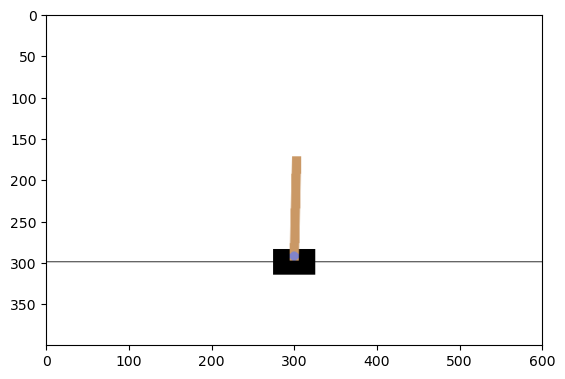

In [6]:
plt.imshow(env.render())
plt.xlim(0, 600)

The pole angle can be observed between (-.418, .418) radians (or ±24°), but the episode terminates if the pole angle is not in the range (-.2095, .2095) (or ±12°)

In [7]:
env.reset()
images = []
total_reward = 0

game_over = False
while not game_over:
    action = random.choice([0, 1])   # random go left or right
    obs, reward, done, _, info = env.step(action)
    
    total_reward += reward
    
    # Capture rendered image
    images.append(env.render())
    
    if done:
        game_over = True
print(f"Total reward is {total_reward}.")

Total reward is 27.0.


## Testing simple policies

### Radnom policy

In [8]:
def random_policy():
    return random.choice([0, 1])

In [9]:
totals = []
for episode in range(500):
    episode_reward = 0
    obs = env.reset()[0]
    
    for step in range(200):
        action = random_policy()
        obs, reward, done, _, info = env.step(action)
        episode_reward += reward
    
        if done:
            break
        
    totals.append(episode_reward)

In [10]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(22.136, 12.190713842921587, 9.0, 106.0)

### Angle policy

If the pole is tilted to the right, go right; if it's tilted to the left, go left.

In [11]:
def angle_policy(obs):
    angle = obs[2]
    return 0 if angle<0 else 1

In [12]:
totals = []
for episode in range(500):
    episode_reward = 0
    obs = env.reset()[0]
    
    for step in range(200):
        action = angle_policy(obs)
        obs, reward, done, _, info = env.step(action)
        episode_reward += reward
    
        if done:
            break
        
    totals.append(episode_reward)

In [13]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(41.996, 8.44274742012338, 24.0, 67.0)

### Visualization

In [14]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    plt.title("CartPole")
    plt.xlim(0, 600)
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    
    return anim

In [17]:
steps_taken = 0
frames = []
obs = env.reset()[0]

while steps_taken < 200:
    action = angle_policy(obs)
    obs, reward, done, _, info = env.step(action)
    
    img = env.render()
    frames.append(img)
    
    if done:
        break
    
    steps_taken += 1
steps_taken

67

In [18]:
anim = plot_animation(frames)
HTML(anim.to_html5_video())

## Neural nework approach (Gradient Policy)

In [19]:
env.reset()

(array([0.02178564, 0.03524877, 0.04651117, 0.00736984], dtype=float32), {})

### Neural network architecture

In [20]:
n_inputs = env.observation_space.shape[0]

model = nn.Sequential(
    nn.Linear(n_inputs, 5),
    nn.ELU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
)

In [21]:
def play_one_step(env, obs, model, loss_fn):
    """
    Plays one step of the game.

    Args:
        env (gym.Env): The environment.
        obs (np.ndarray): The current observation.
        model (torch.nn.Module): The neural network model.
        loss_fn (torch.nn.Module): The loss function.

    Returns:
        tuple: A tuple containing:
            - obs (np.ndarray): The new observation.
            - reward (float): The reward obtained from the action.
            - done (bool): Whether the game is done or not.
            - loss (torch.Tensor): The loss calculated for this step.
    """
    # Predict the probability of moving left using the neural network model
    left_proba = model(torch.tensor(obs, dtype=torch.float32))
    
    # Choose the action based on the probability
    # If a randomly generated number is greater than the probability of moving left,
    # choose the action to move right; otherwise, choose to move left
    action = int(torch.rand(1) > left_proba)
    
    # Reshape left_proba to have the same shape as y_target
    # This ensures consistency in shapes for calculating the loss
    left_proba = left_proba.view(1, 1)
    
    # Calculate the target value for the loss
    # We calculate the target value as 1 - action because for binary classification,
    # if the action is 1 (moving left), the target should be 0, and vice versa
    y_target = torch.tensor([[1.]], dtype=torch.float32) - action
    
    # Calculate the loss using the binary cross-entropy loss function
    # We use left_proba and y_target to calculate the loss
    loss = loss_fn(left_proba, y_target)
    
    # Take the chosen action in the environment
    # Obtain the new observation, reward, done status, and additional info
    obs, reward, done, _, info = env.step(action)
    
    return obs, reward, done, loss

In [22]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    """
    Plays multiple episodes of the game.

    Args:
        env (gym.Env): The environment.
        n_episodes (int): Number of episodes to play.
        n_max_steps (int): Maximum number of steps per episode.
        model (torch.nn.Module): The neural network model.
        loss_fn (torch.nn.Module): The loss function.

    Returns:
        tuple: A tuple containing:
            - all_rewards (list): List of rewards obtained for each episode.
            - all_losses (list): List of losses calculated for each episode.
    """
    # Initialize lists to store rewards and losses for each episode
    all_rewards = []
    all_losses = []
    
    # Iterate over each episode
    for episode in range(n_episodes):
        current_rewards = []  # List to store rewards for the current episode
        current_losses = []   # List to store losses for the current episode
        
        # Reset the environment and get the initial observation
        obs = env.reset()[0]
        
        # Iterate over each step within the episode
        for step in range(n_max_steps):
            # Play one step of the game and obtain the new observation, reward, done status, and loss
            obs, reward, done, loss = play_one_step(env, obs, model, loss_fn)
            
            # Append the reward and loss to the lists
            current_rewards.append(reward)
            current_losses.append(loss)
            
            # Check if the episode is done
            if done:
                break
        
        # Append the rewards and losses for the current episode to the overall lists
        all_rewards.append(current_rewards)
        all_losses.append(current_losses)
    
    # Return the lists of rewards and losses for all episodes
    return all_rewards, all_losses

In [23]:
def discount_rewards(rewards, discount_factor):
    """
    Discounts the rewards using a discount factor.

    Args:
        rewards (list): List of rewards.
        discount_factor (float): Discount factor.

    Returns:
        np.ndarray: Discounted rewards.
    """
    # Convert the list of rewards to a numpy array for efficient computation
    discounted = np.array(rewards)
    
    # Iterate over the rewards in reverse order, starting from the second-to-last reward
    for step in range(len(rewards) - 2, -1, -1):
        # Update the current reward by adding the discounted future rewards
        # Multiply the next reward by the discount factor and add it to the current reward
        # This discounts future rewards and sums them up to the current reward
        discounted[step] += discounted[step + 1] * discount_factor
    
    # Return the discounted rewards as a numpy array
    return discounted


In [24]:
def discount_and_normalize_rewards(all_rewards, discount_factor):
    """
    Discounts and normalizes the rewards.

    Args:
        all_rewards (list): List of rewards for all episodes.
        discount_factor (float): Discount factor.

    Returns:
        list: Discounted and normalized rewards.
    """
    # Discount the rewards for all episodes using the provided discount factor
    all_discounted_rewards = [discount_rewards(rewards, discount_factor) for rewards in all_rewards]
    
    # Concatenate all discounted rewards into a single array
    flat_rewards = np.concatenate(all_discounted_rewards)
    
    # Calculate the mean and standard deviation of the concatenated rewards
    reward_mean = flat_rewards.mean()  # Calculate the mean reward across all episodes
    reward_std = flat_rewards.std()    # Calculate the standard deviation of rewards across all episodes
    
    # Normalize each episode's discounted rewards using the calculated mean and standard deviation
    normalized_rewards = [(discount_rewards - reward_mean) / reward_std
                          for discount_rewards in all_discounted_rewards]
    
    # Return the list of normalized rewards
    return normalized_rewards

In [25]:
n_iterations = 600
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCELoss()

In [26]:
mean_rewards_history = []  # Initialize an empty list to store mean rewards for each iteration

# Loop through the specified number of iterations
for iteration in range(n_iterations):
    # Play multiple episodes of the game and obtain rewards and losses for each episode
    all_rewards, all_losses = play_multiple_episodes(env, n_episodes_per_update, n_max_steps, model, loss_fn)
    
    # Calculate the total rewards obtained across all episodes
    total_rewards = sum(map(sum, all_rewards))
    # Calculate the mean rewards per episode
    mean_rewards = total_rewards / n_episodes_per_update
    
    # Print the current iteration number and mean rewards
    print("\rIteration: {}, mean rewards: {:.1f}".format(iteration, mean_rewards), end="")
    
    # Append the mean rewards to the history list
    mean_rewards_history.append(mean_rewards)
    
    # Discount and normalize the rewards obtained from all episodes
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)
    
    # Initialize an empty list to store the final losses after discounting and normalizing
    all_final_losses = []
    
    # Iterate over each episode's losses and apply discounting and normalization
    for episode_index, episode_losses in enumerate(all_losses):
        for step, loss in enumerate(episode_losses):
            # Multiply each loss by the corresponding discounted and normalized reward
            all_final_losses.append(all_final_rewards[episode_index][step] * loss)
    
    # Zero the gradients of the optimizer
    optimizer.zero_grad()
    
    # Stack all final losses into a single tensor and sum them up
    loss = torch.stack(all_final_losses).sum()
    
    # Backpropagate the loss
    loss.backward()
    
    # Update the model parameters using the optimizer
    optimizer.step()

Iteration: 599, mean rewards: 200.0

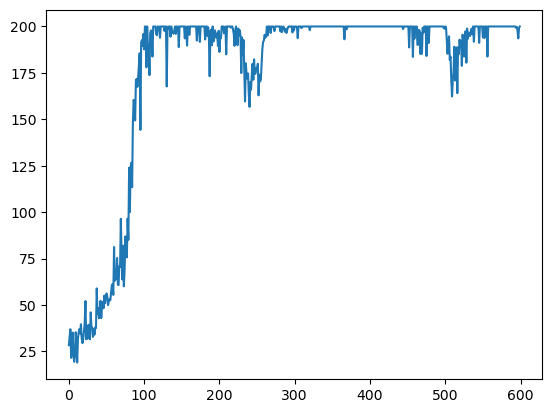

In [27]:
plt.plot(mean_rewards_history)

In [28]:
def run_inference(env, model, max_steps=500):
    """
    Runs inference with the model for a maximum number of steps or until a game error occurs.

    Args:
        env (gym.Env): The environment.
        model (torch.nn.Module): The neural network model.
        max_steps (int, optional): Maximum number of steps to run inference. Defaults to 500.

    Returns:
        int: Number of steps taken.
    """
    steps_taken = 0
    frames = []
    obs = env.reset()[0]

    while steps_taken < max_steps:
        left_proba = model(torch.tensor(obs, dtype=torch.float32))
        action = int(torch.rand(1) > left_proba)
        
        img = env.render()
        frames.append(img)
        
        obs, reward, done, _, info = env.step(action)
        
        steps_taken += 1
        if done:
            # Continue last action for 25 more times after failing to balance pole
            # Ensuring that pole keeps falling after 24 degrees angle
            for _ in range(20):
                obs, reward, done, _, info = env.step(action)
                img = env.render()
                frames.append(img)
            break  # Break out of the loop if the game is done
    
    return steps_taken, frames

In [29]:
# Usage example:
env = gym.make("CartPole-v1", render_mode="rgb_array")
num_steps, frames = run_inference(env, model, max_steps=1000)
print(f"Number of steps taken: {num_steps}")

/home/jovo/anaconda3/envs/myprojects/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Number of steps taken: 317


/home/jovo/anaconda3/envs/myprojects/lib/python3.9/site-packages/gym/envs/classic_control/cartpole.py:177: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


In [30]:
anim = plot_animation(frames)
HTML(anim.to_html5_video())